In [2]:
import seaborn as sns

from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose

### Running data

Data read with shape (101466, 555) and stored in variable df
Dataset organized by domain stored in variable df_domains.
Domain names: Index(['zh', 'fr', 'en', 'de', 'ru', 'nt', 'ja', 'es'], dtype='object')


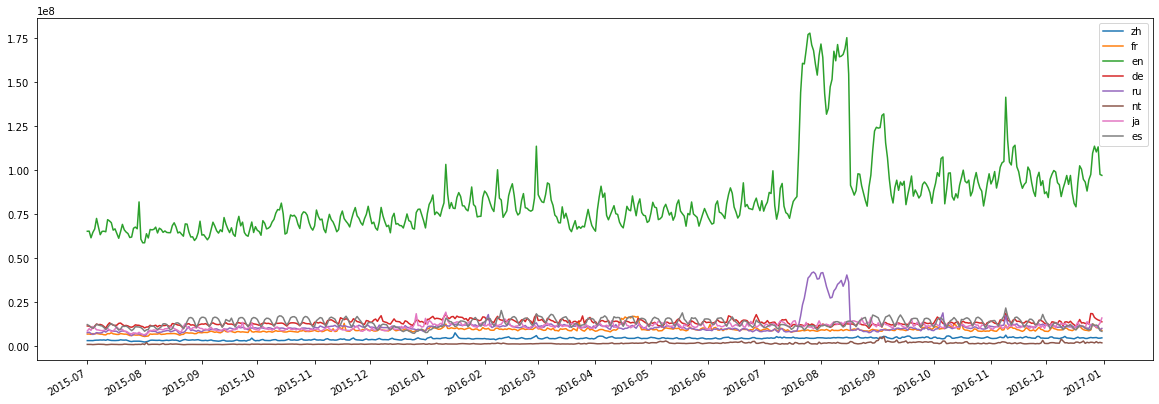

In [3]:
%run data_domains.ipynb

### Series selection

Select a time series to work on the forecasting.

In [4]:
series = df_domains['en']
series

2015-07-01     65168952.0
2015-07-02     65252461.0
2015-07-03     61463981.0
2015-07-04     64504975.0
2015-07-05     66471570.0
                 ...     
2016-12-27    113574925.0
2016-12-28    110288330.0
2016-12-29    113192324.0
2016-12-30     97504193.0
2016-12-31     96975637.0
Name: en, Length: 550, dtype: object

Because of the non float columns in the previous dataframe, it lost the `float` type as we can see.

In [5]:
series.dtypes

dtype('O')

In [6]:
series = series.astype('float64')

In [7]:
series.describe()

count    5.500000e+02
mean     8.346204e+07
std      2.194735e+07
min      5.861329e+07
25%      7.005340e+07
50%      7.743339e+07
75%      8.942188e+07
max      1.778737e+08
Name: en, dtype: float64

### Distribution

This histogram will tell us the distribution of number of acceses in a day. We can clearly see a distribution made and there's some outsiders in it. They're all on the right side which means there' could potentially be an event occuring some days so people accessed more on wikipedia.

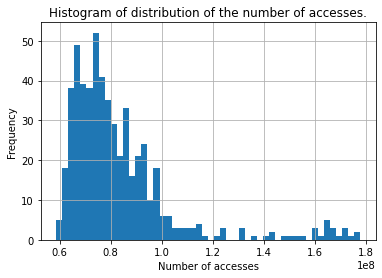

In [8]:
fig, ax = plt.subplots()
ax.set_title('Histogram of distribution of the number of accesses.')
ax.set_xlabel('Number of accesses')
ax.set_ylabel('Frequency')
series.hist(bins=50,ax=ax)
plt.show()

Better visualization with the `seaborn` package.

c:\DEV\AnSeqData\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


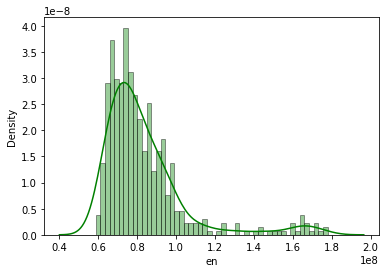

In [9]:
sns.distplot(series, hist=True, kde=True, 
             bins=50, color = 'green',
             hist_kws={'edgecolor':'black'})
plt.show()

The box representation will make mark us even more the outsiders (with the black dots) which they're clearly higher than $Q_4$.

<AxesSubplot:>

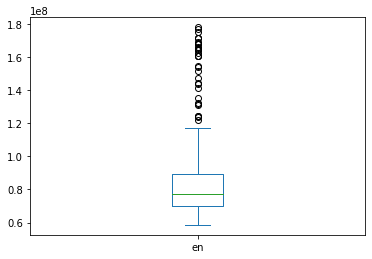

In [10]:
series.plot.box()

The `Q-Q plot` will tell us if it follows a normal distribution. Of course, it won't as the left plot shows the blue dots don't follow the red line. There's [multiple distributions that scipy](https://docs.scipy.org/doc/scipy/reference/tutorial/stats/continuous.html) gives us to try. It will never be perfect because of the probable "events" occuring in the series. But it will follow more the end of the distribution.

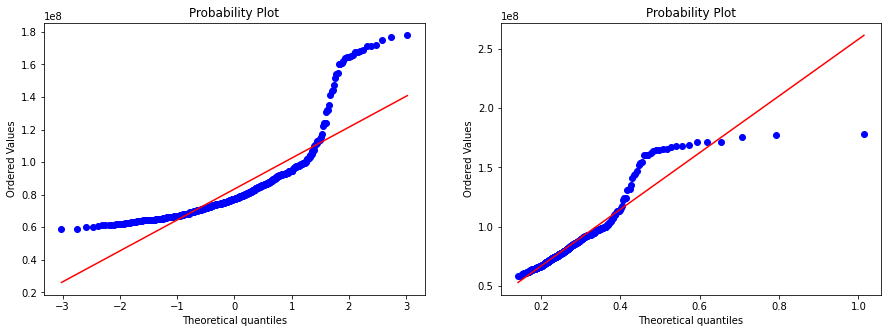

In [11]:
fig, ax= plt.subplots(ncols=2,figsize=(15,5))
stats.probplot(series, dist="norm", plot=ax[0])
stats.probplot(series,dist=stats.alpha, sparams=(4.,), plot=ax[1])
plt.show()

### Autocorrelation

Multiple observations can be made with the following plot:
* The auto-correlation plot shows a slow decrease in the values.
* The partial auto-correlation plot shows high values for $p=1$. (When $p=0$ the PAF is $1.0$ because we correlate with himself.)

This means that our problems is an `AR(1)` series which represents a series having a dependancy with the previous value of the series. ($a$, $b$ are constants and $\epsilon$ a white noise)

$$X_{t}=a+bX_{t-1}+\epsilon_{t}$$

The problem is not a RW because the value $b$ is less than $1.0$.

c:\DEV\AnSeqData\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


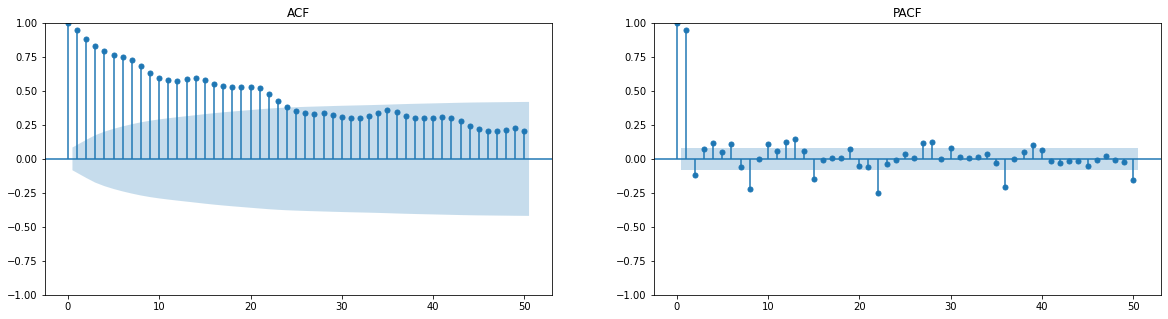

In [12]:
fig, ax = plt.subplots(ncols=2,figsize=(20,5))

acf_plot = plot_acf(series, lags=50, title='ACF',ax=ax[0])
pacf_plot = plot_pacf(series, lags=50, title='PACF',ax=ax[1])

plt.show()

Sometimes it can be usefull to plot the *ACF* and *PACF* with the data squared because they become unbiased estimators.

c:\DEV\AnSeqData\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


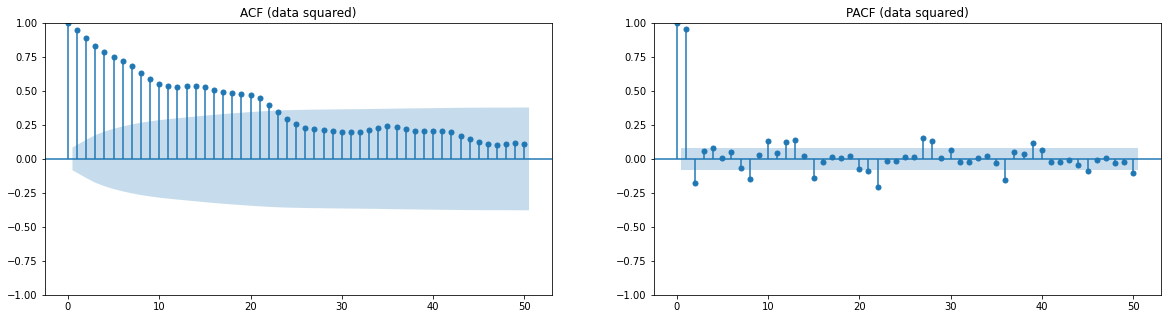

In [13]:
fig, ax = plt.subplots(ncols=2,figsize=(20,5))

acf_plot = plot_acf(series**2, lags=50, title='ACF (data squared)',ax=ax[0])
pacf_plot = plot_pacf(series**2, lags=50, title='PACF (data squared)',ax=ax[1])

plt.show()

### Stationnarity

This section determines if the series is stationnary or not. If it is we won't have a trend on the curve. If we divide in chunks our data, it will stay in place with a simmilary mean in each chunks.

In this project, it will apply multiple stationnarity tests and make a mean of the p-value to see if it rejects or not the null hypothesis with $\alpha=0.05$.
1. **Null hypothesis:** the series is nonstationary.
2. **Alternative hypothesis:** the series is stationary.

In [14]:
ALPHA = 0.05

In [15]:
adf, pvalue_adf, _, _, critical_values_adf, _ = adfuller(series)

In [16]:
print('Augmented Dickey-Fuller')
print(f"ADF: {adf}")
print(f"p-value: {pvalue_adf}")
print(f"crit values: {critical_values_adf}")

Augmented Dickey-Fuller
ADF: -2.3798014125164046
p-value: 0.14751864896890488
crit values: {'1%': -3.4426321555520905, '5%': -2.86695748394138, '10%': -2.5696553279762426}


In [17]:
test_kpss, pvalue_kpss, usedlag, critical_values_kpss = kpss(series)

c:\DEV\AnSeqData\venv\lib\site-packages\statsmodels\tsa\stattools.py:1998: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [18]:
print('Kwiatkowski-Phillips-Schmidt-Shin')
print(f"ADF: {test_kpss}")
print(f"p-value: {pvalue_kpss}")
print(f"crit values: {critical_values_kpss}")

Kwiatkowski-Phillips-Schmidt-Shin
ADF: 1.6565978966624282
p-value: 0.01
crit values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


In [19]:
(pvalue_adf+pvalue_kpss)/2 > ALPHA

True

It looks like it's higher but not by a lot, we still set a null hypothesis meaning it is a nonstationnary series.

### Series decomposition

This decomposition can make us learn more about the trend and seasonality on the series. Because of the daily data, we use $period=7$ so it has a weekly seasonality.

Two information can be extracted with this decomposition:
* There's a small trend visible on the series.
* The plot shows clear seasonality for a weekly period.

In [20]:
ss_decomposition = seasonal_decompose(x=series, model='multiplicative',period=7)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

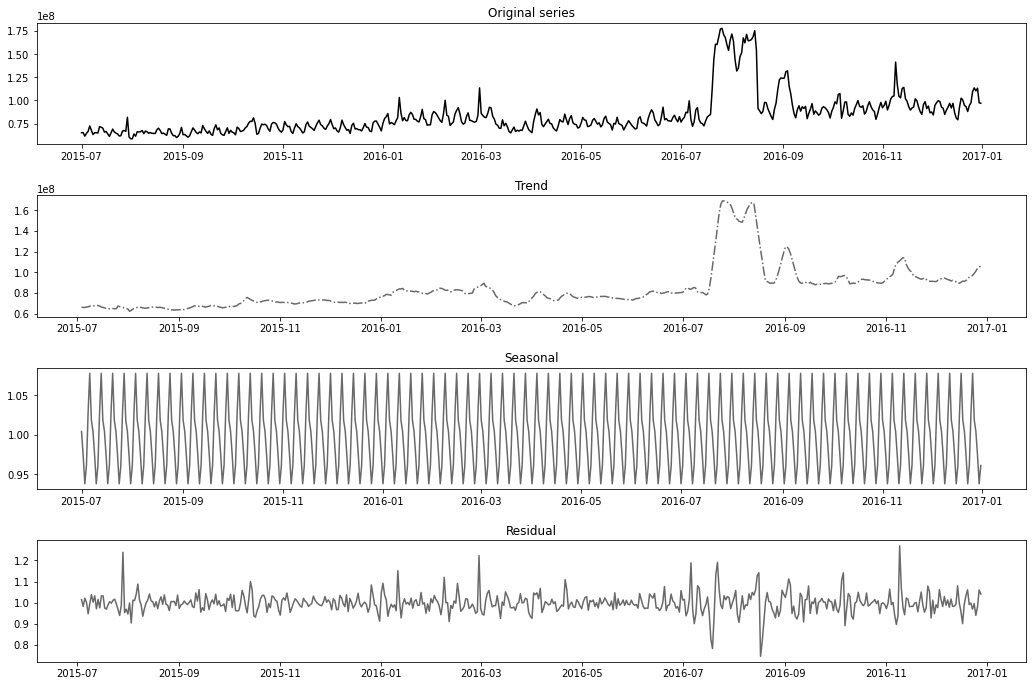

In [21]:
fig, ax = plt.subplots(nrows=4,figsize=(15,10))

fig.tight_layout(pad=3.0)

ax[0].set_title('Original series')
ax[0].plot(series,color='black')

ax[1].set_title('Trend')
ax[1].plot(estimated_trend,color='dimgray',linestyle='-.')

ax[2].set_title('Seasonal')
ax[2].plot(estimated_seasonal,color='dimgray',linestyle='-')

ax[3].set_title('Residual')
ax[3].plot(estimated_residual,color='dimgray',linestyle='-')

plt.show()
